### Importing required Libraries

In [1]:
# API keys
import os 
from dotenv import load_dotenv

# For LLM
from langchain_groq import ChatGroq

# Document Loader
from langchain_community.document_loaders.csv_loader import CSVLoader

# Embedding model
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

# Type validation
from pydantic import BaseModel,Field

# Vector DB
from pinecone import ServerlessSpec,Pinecone
from langchain_pinecone import PineconeVectorStore
from uuid import uuid4


# Output Parser for desired output structure
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

# LangGrapgh Workflow
from langgraph.graph import StateGraph,MessagesState,START,END
from typing import TypedDict,List


c:\Users\divya\Documents\GitHub\Agentic\myvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Loading API keys

In [2]:


load_dotenv()

True

#### Setting up LLM

In [3]:


llm=ChatGroq(model='llama-3.1-8b-instant')
llm.invoke("Hello")

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.011120941, 'prompt_time': 0.212150615, 'queue_time': 0.201290364, 'total_time': 0.223271556}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c523237e5d', 'finish_reason': 'stop', 'logprobs': None}, id='run--e73d0cea-fb64-48f7-8d63-13aed857fcbe-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

#### Document Loader to load `wine_reviews` Dataset

In [4]:


loader=CSVLoader(file_path=r'C:\Users\divya\Documents\GitHub\Agentic\RAG_Based_Projects\winemag-data-130k-v2.csv',encoding='utf-8')
docs=loader.load()

In [5]:
len(docs)

129971

#### Hugging Face Embedding model for Vectore DB

In [20]:


embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

embedding_dim = len(embeddings.embed_query("hello world"))
embedding_dim

384

#### Setting up Pinecone vector DB

In [7]:


pinecone_api_key = os.environ.get("PINECONE_API_KEY")
pc = Pinecone(api_key=pinecone_api_key)

index_name = "wine-rag-pipelin"  

if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=embedding_dim,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

index = pc.Index(index_name)

##### Loading Documents in Vector DB

In [8]:


vector_store = PineconeVectorStore(index=index, embedding=embeddings)



uuids = [str(uuid4()) for _ in range(len(docs))]


##### Total Records

In [9]:
len(uuids)

129971

In [10]:
#vector_store.add_documents(documents=docs, ids=uuids)

In [ ]:
class StructuredOutput(BaseModel):
    country:str = Field(description="country name")
    wine:str = Field(description="Wine name")
    price_in_USD:int = Field(description="Wine price")
    wine_variety:str = Field(description="wine variety")
    Reason:str = Field(description="Reasoning for this suggestion in 4-5 lines")

### LangGrapgh for defining RAG workflow

#### Defining State

In [12]:
class State(TypedDict):
    question:str
    context:List[str]
    answer:str

In [13]:
graph=StateGraph(State)

In [14]:
def retrieve(state:State):
    
    #print(state)

    retriever=vector_store.as_retriever(search_kwargs={"k": 3} )

    retrival_result=retriever.invoke(state['question'])
    result=[]
    for res in retrival_result:
        result.append(res.page_content)


    return {"context":result}


In [15]:
def generate(state:State):
    
    #print(state)
    parser=PydanticOutputParser(pydantic_object=StructuredOutput)

    format_instructions = parser.get_format_instructions()

    template= """ You are an assistant for question-answering tasks. Use the following pieces of retrieved context to 
    answer the question. If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise in format : {format_instructions}
    Question: {question} 
    Context: {context} 
    Answer: """

    prompt=PromptTemplate(
        template=template,
        input_variables=["question","context"],
        partial_variables={"format_instructions": format_instructions}
    )
    
    rag= prompt | llm 
    
    answer=rag.invoke({"question":state['question'],"context":state['context']})
    
    return {'answer':answer.content}

In [16]:
graph.add_node("Retrive",retrieve)
graph.add_node("Generate",generate)


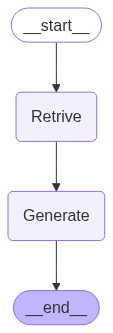

In [17]:
graph.add_edge(START,"Retrive")
graph.add_edge("Retrive","Generate")
graph.compile()

In [18]:
rag_pipeline=graph.compile()

In [19]:
for step in rag_pipeline.stream(
    {"question":"Suggest a celebratory wine for an anniversary dinner"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'Retrive': {'context': [": 41150\ncountry: US\ndescription: Made from 100% Chardonnay, this wine is marketed to celebrate wedding anniversaries. It's as light as a feather, with a fine, silky mousse framing orange, lime, vanilla, honey and yeasty sourdough flavors. Delicious and elegant, it's a wine to toast with almost anything, including wedding cake.\ndesignation: Anniversary Cuvée\npoints: 90\nprice: 40.0\nprovince: California\nregion_1: Carneros\nregion_2: Napa-Sonoma\ntaster_name: \ntaster_twitter_handle: \ntitle: Gloria Ferrer 2008 Anniversary Cuvée Sparkling (Carneros)\nvariety: Sparkling Blend\nwinery: Gloria Ferrer", ': 92425\ncountry: France\ndescription: Calling a wine romantic is perhaps a new approach for Bordeaux. The wine itself is ripe and jammy, with wood tannins that will be softer in a year. Drink from 2016.\ndesignation: Romantique\npoints: 86\nprice: 10.0\nprovince: Bordeaux\nregion_1: Bordeaux\nregion_2: \ntaster_name: Roger Voss\ntaster_twitter_handle: @vossrog